# Лабораторная работа №4
###  Исходные данные
**Датасет**: https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions
<br>
**Предметная область**: Человеческая активность, различные движения
<br>**Список классов**:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING
7. STAND_TO_SIT
8. SIT_TO_STAND
9. SIT_TO_LIE
10. LIE_TO_SIT
11. STAND_TO_LIE
12. LIE_TO_STAND

**Количество атрибутов**: 561
<br>
**Основные атрибуты**: Измерения гироскопа и акселерометра в 3х осях, фильтры их значений
<br>
**Полный список атрибутов**: Features.txt
### Ход работы
#### Исходный код


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
import warnings; warnings.simplefilter('ignore')

import utils
from data import Data


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


def test_kernel_functions(data):
    C = 1.0
    svc = svm.SVC(kernel='linear', C=C).fit(data.train_data, data.train_classes)
    lin_svc = svm.LinearSVC(C=C).fit(data.train_data, data.train_classes)
    rbf_svc = svm.SVC(kernel='rbf', C=C).fit(data.train_data, data.train_classes)
    sigmoid_svc = svm.SVC(kernel='sigmoid', C=C).fit(data.train_data, data.train_classes)
    poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(data.train_data, data.train_classes)

    titles = ['SVC with linear kernel',
              'LinearSVC (linear kernel)',
              'SVC with rbf kernel',
              'SVC with sigmoid kernel',
              'SVC with poly kernel']

    for i, clf in enumerate((svc, lin_svc, rbf_svc, sigmoid_svc, poly_svc)):
        pred = clf.predict(data.test_data)
        print('Accuracy for {}: {:.2%}'.format(titles[i], metrics.accuracy_score(data.test_classes, pred)))


def linear_c_test(data):
    C_range = np.logspace(-2, 7, 10)
    param_grid = dict(C=C_range)

    scores = get_svc_accuracy(param_grid, len(C_range), 1, data)

    draw(scores, C_range, [1], 'c', '')



def get_svc_accuracy(param_grid, fst_length, scnd_length, data):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=param_grid, cv=cv)
    grid.fit(data.data, data.classes)

    return grid.cv_results_['mean_test_score'].reshape(scnd_length, fst_length)


def draw(scores, fst_range, scnd_range, fst_name, scnd_name):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.86))
    plt.xlabel(fst_name)
    plt.ylabel(scnd_name)
    plt.colorbar()
    plt.xticks(np.arange(len(fst_range)), fst_range, rotation=45)
    plt.yticks(np.arange(len(scnd_range)), scnd_range)
    plt.title('Validation accuracy')
    plt.show()



Ввиду слишком долгого вычисления в этой реализации, возьмем небольшой набор данных из исходного датасета

Сравним следующие ядра:

1. SVC with linear kernel,
2. LinearSVC,
3. SVC with rbf kernel,
4. SVC with sigmoid kernel,
5. SVC with poly kernel,


In [14]:
    file_data, file_classes = utils.load_data()
    data = Data(file_data, file_classes, 0.1,  0.7, 30)
    test_kernel_functions(data)


Accuracy for SVC with linear kernel: 76.82%
Accuracy for LinearSVC (linear kernel): 75.54%
Accuracy for SVC with rbf kernel: 50.64%
Accuracy for SVC with sigmoid kernel: 42.06%
Accuracy for SVC with poly kernel: 35.19%


Из результатов сравнения видно, что лучше всего показало себя SVC с линейным ядром<br>
Есть ещё параметр С общий для всех ядер SVM. Является регулирующей константой, разрешающей конфликт между двумя задачами: максимизацией зазора и минимизацией потерь.
<br><br>
Посмотрим, как влияет изменения С на способность предсказания классов:



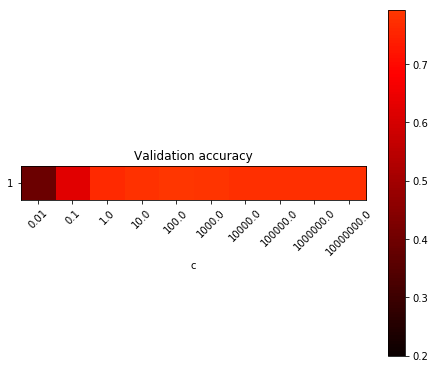

In [15]:
linear_c_test(data)

На графике немного плохо видно, но при C~900 достигается наибольшая точность. Проверим показатели линейного ядра:



In [24]:
poly_svc = svm.SVC(kernel='linear', C=900).fit(data.train_data, data.train_classes)
pred = poly_svc.predict(data.test_data)

print('Accuracy: {:.2%}'.format(metrics.accuracy_score(data.test_classes, pred)))


Accuracy: 82.83%


### Вывод



Для данного набора данных наиболее оптимальным будет использование линейного ядра SVC с C=900. В целом метод опорных векторов подходит для использования на данном наборе данных с учетом того, что данных бралось меньше полноценного набора из за сложности вычислений на ноутбуке.